In [1]:
import pandas as pd
import os

In [13]:
images = os.listdir('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/img')
csv_for_bbx = pd.read_csv('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/labels.csv')

In [14]:
images[0]

'9.png'

In [17]:
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.patches as patches
import matplotlib.pyplot as plt

model = torch.load("/home/bharathraj/Documents/geoml-wd/models/bdappvFasterRCNN.pt", map_location=torch.device('cpu'))



def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')



def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].cpu()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

def remove_low_score_boxes(prediction, threshold):
    boxes = prediction['boxes'][prediction['scores'] > threshold]
    scores = prediction['scores'][prediction['scores'] > threshold]
    labels = prediction['labels'][prediction['scores'] > threshold]
    
    prediction['boxes'] = boxes
    prediction['scores'] = scores
    prediction['labels'] = labels
    
    return prediction


def predict(image):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    img = torchtrans.ToTensor()(image)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    prediction = apply_nms(prediction, iou_thresh=0.3)
    prediction = remove_low_score_boxes(prediction, threshold=0.8)

    plot_img_bbox(image, prediction)
    return prediction



In [12]:
images[0]

'img'

In [77]:
label_of_first_image = """
1 0.550027 0.836386 0.158211 0.085470
1 0.682883 0.769590 0.048004 0.111327
1 0.691673 0.613733 0.035834 0.020829
1 0.689644 0.639948 0.037186 0.018674
1 0.689982 0.685197 0.036510 0.053149
1 0.711280 0.463262 0.053413 0.122100
1 0.702828 0.328952 0.082486 0.124973
1 0.586199 0.319615 0.080458 0.094807
1 0.568620 0.453566 0.057470 0.092652
1 0.627104 0.466494 0.102769 0.092652
1 0.529405 0.591467 0.041243 0.059614
1 0.632851 0.077569 0.057470 0.064641
1 0.881999 0.882712 0.036510 0.018674
1 0.878618 0.909287 0.035158 0.020111
"""

label_of_first_image = label_of_first_image.split('\n')[1:-1]
label_of_first_image = [i.split(' ') for i in label_of_first_image]

label_of_first_image


[['1', '0.550027', '0.836386', '0.158211', '0.085470'],
 ['1', '0.682883', '0.769590', '0.048004', '0.111327'],
 ['1', '0.691673', '0.613733', '0.035834', '0.020829'],
 ['1', '0.689644', '0.639948', '0.037186', '0.018674'],
 ['1', '0.689982', '0.685197', '0.036510', '0.053149'],
 ['1', '0.711280', '0.463262', '0.053413', '0.122100'],
 ['1', '0.702828', '0.328952', '0.082486', '0.124973'],
 ['1', '0.586199', '0.319615', '0.080458', '0.094807'],
 ['1', '0.568620', '0.453566', '0.057470', '0.092652'],
 ['1', '0.627104', '0.466494', '0.102769', '0.092652'],
 ['1', '0.529405', '0.591467', '0.041243', '0.059614'],
 ['1', '0.632851', '0.077569', '0.057470', '0.064641'],
 ['1', '0.881999', '0.882712', '0.036510', '0.018674'],
 ['1', '0.878618', '0.909287', '0.035158', '0.020111']]

In [78]:
label_of_first_image[1]

['1', '0.682883', '0.769590', '0.048004', '0.111327']

In [79]:
images.sort()
images[0]

'1.png'

In [80]:
# conver the YOLO format to the format to left x, top y, width, height format

def convert_yolo_to_voc(image, label):
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/img/'+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    label = [float(i) for i in label]
    label[1] = label[1] * width
    label[2] = label[2] * height
    label[3] = label[3] * width
    label[4] = label[4] * height
    label[1] = label[1] - label[3]/2
    label[2] = label[2] - label[4]/2
    label[3] = label[1] + label[3]
    label[4] = label[2] + label[4]
    return label

label_of_first_image = [convert_yolo_to_voc(images[0], i) for i in label_of_first_image]
label_of_first_image


[[1.0, 313.1627975, 496.82552599999997, 418.3731125, 550.329746],
 [1.0, 438.15586500000006, 446.917989, 470.07852500000007, 516.608691],
 [1.0, 448.04774, 377.67738099999997, 471.87735, 390.71633499999996],
 [1.0, 446.248915, 394.76248599999997, 470.977605, 406.45241],
 [1.0, 446.698455, 412.297685, 470.97760500000004, 445.568959],
 [1.0, 455.24137750000006, 251.78471199999998, 490.7610225000001, 328.219312],
 [1.0, 439.954025, 166.80740300000002, 494.807215, 245.040501],
 [1.0, 363.07005000000004, 170.40439899999998, 416.57462000000004, 229.753581],
 [1.0, 359.023525, 254.93224, 397.241075, 312.932392],
 [1.0, 382.85346749999997, 263.025168, 451.19485249999997, 321.02532],
 [1.0, 338.3410275, 351.59916, 365.7676225, 388.91752399999996],
 [1.0, 401.73714000000007, 28.325561, 439.9546900000001, 68.79082700000001],
 [1.0, 574.3897599999999, 546.73275, 598.6689099999999, 558.422674],
 [1.0, 572.5909350000001, 562.918919, 595.9710050000001, 575.5084049999999]]

In [81]:
# function to convert the bounding box labels to the format required by torchvision

def convert_bboxes_to_target(labels):
    boxes = []
    for label in labels:
        boxes.append([float(label[1]), float(label[2]), float(label[3]), float(label[4])])
    boxes = torch.tensor(boxes)
    labels = torch.tensor([int(label[0]) for label in labels])
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['scores'] = torch.ones((len(labels),), dtype=torch.float32)
    return target

target = convert_bboxes_to_target(label_of_first_image)
target

{'boxes': tensor([[313.1628, 496.8255, 418.3731, 550.3298],
         [438.1559, 446.9180, 470.0785, 516.6087],
         [448.0477, 377.6774, 471.8773, 390.7163],
         [446.2489, 394.7625, 470.9776, 406.4524],
         [446.6985, 412.2977, 470.9776, 445.5690],
         [455.2414, 251.7847, 490.7610, 328.2193],
         [439.9540, 166.8074, 494.8072, 245.0405],
         [363.0700, 170.4044, 416.5746, 229.7536],
         [359.0235, 254.9322, 397.2411, 312.9324],
         [382.8535, 263.0252, 451.1949, 321.0253],
         [338.3410, 351.5992, 365.7676, 388.9175],
         [401.7372,  28.3256, 439.9547,  68.7908],
         [574.3898, 546.7327, 598.6689, 558.4227],
         [572.5909, 562.9189, 595.9710, 575.5084]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'scores': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

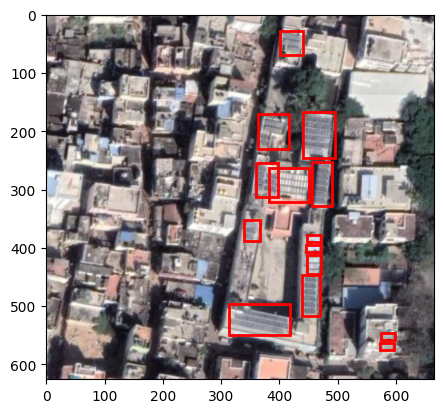

In [82]:
# plot the image and the bounding boxes

img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/img/1.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plot_img_bbox(img, target)

In [87]:
images

['1.png',
 '10.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png']

In [92]:
images = []
for i in range(10):
    images.append(str(i+1)+'.png')

images

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png']

In [107]:
labels_folder = '/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/labels/'

labels = []

for image in images:
    with open(labels_folder+image.split('.')[0]+'.txt', 'r') as f:
        label = f.read()
        label = label.split('\n')
        label = [i.split(' ') for i in label]
        label = [convert_yolo_to_voc(image, i) for i in label]
        label = convert_bboxes_to_target(label)
        labels.append(label)


In [111]:
labels[0]

{'boxes': tensor([[313.1628, 496.8255, 418.3731, 550.3298],
         [438.1559, 446.9180, 470.0785, 516.6087],
         [448.0477, 377.6774, 471.8773, 390.7163],
         [446.2489, 394.7625, 470.9776, 406.4524],
         [446.6985, 412.2977, 470.9776, 445.5690],
         [455.2414, 251.7847, 490.7610, 328.2193],
         [439.9540, 166.8074, 494.8072, 245.0405],
         [363.0700, 170.4044, 416.5746, 229.7536],
         [359.0235, 254.9322, 397.2411, 312.9324],
         [382.8535, 263.0252, 451.1949, 321.0253],
         [338.3410, 351.5992, 365.7676, 388.9175],
         [401.7372,  28.3256, 439.9547,  68.7908],
         [574.3898, 546.7327, 598.6689, 558.4227],
         [572.5909, 562.9189, 595.9710, 575.5084]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'scores': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [120]:
def predict(image):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    img = torchtrans.ToTensor()(image)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    prediction = apply_nms(prediction, iou_thresh=0.3)
    prediction = remove_low_score_boxes(prediction, threshold=0.8)

    return prediction


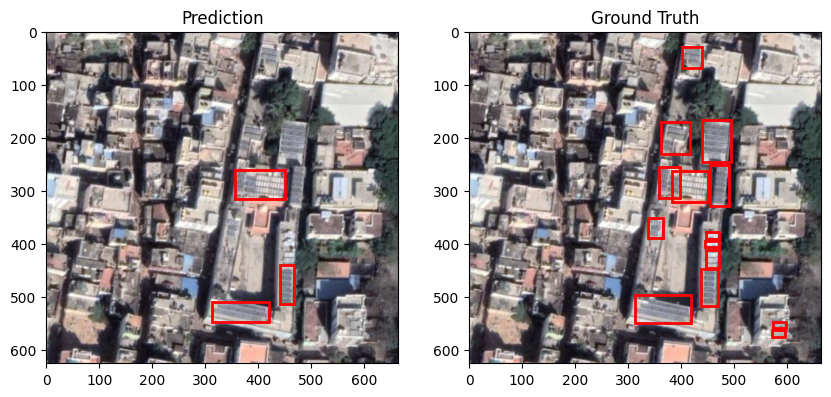

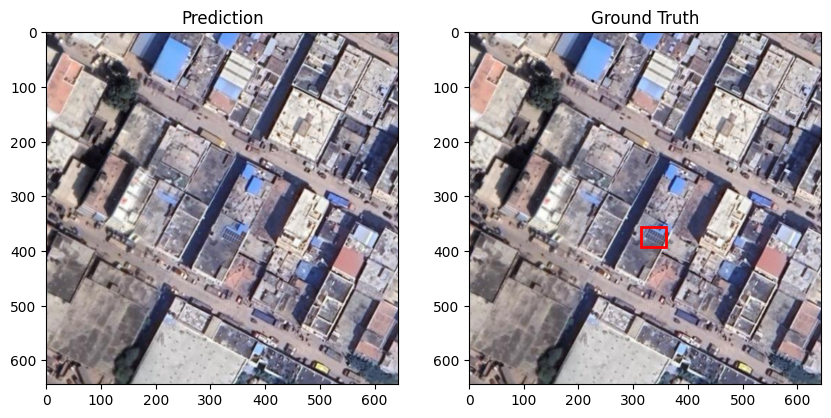

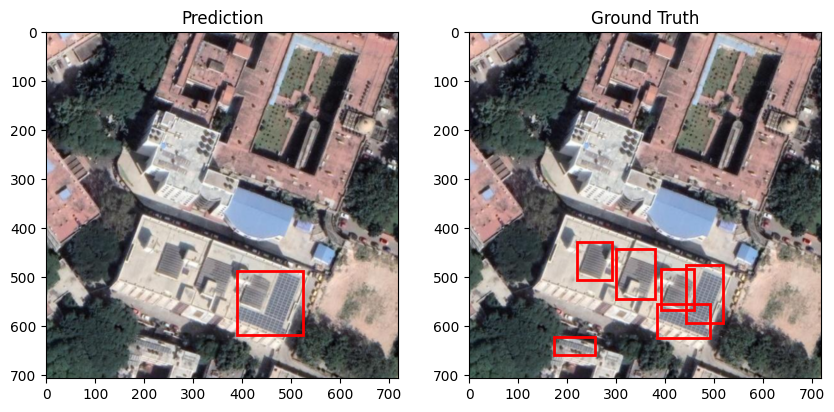

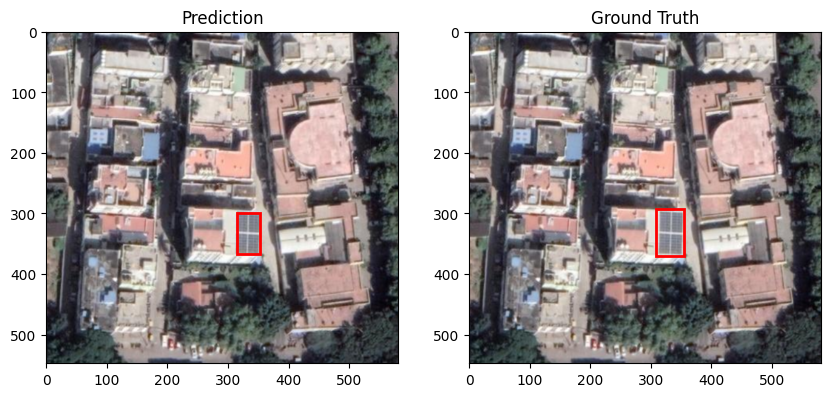

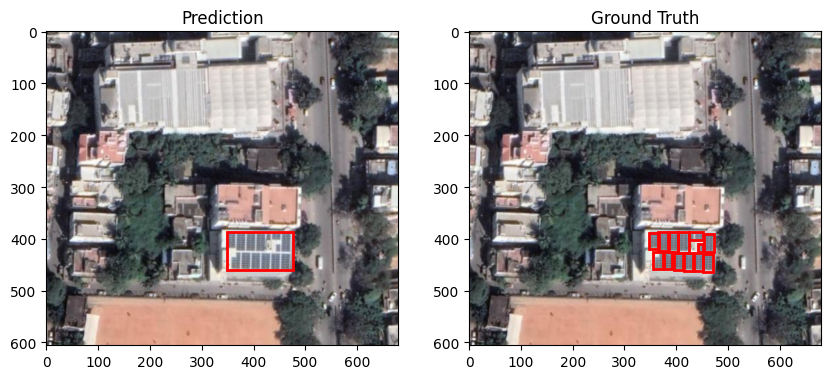

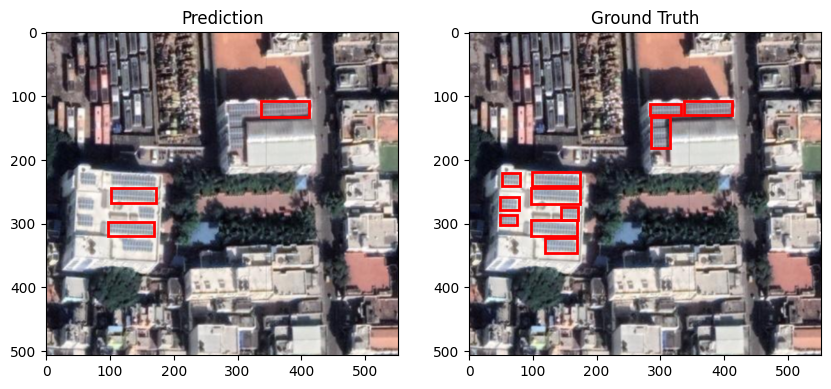

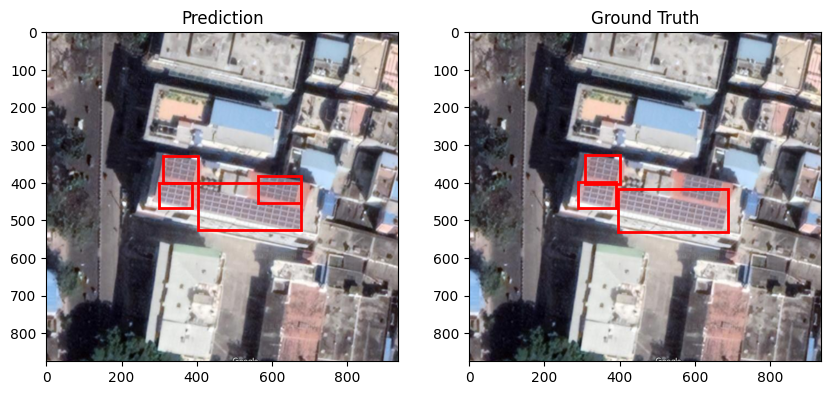

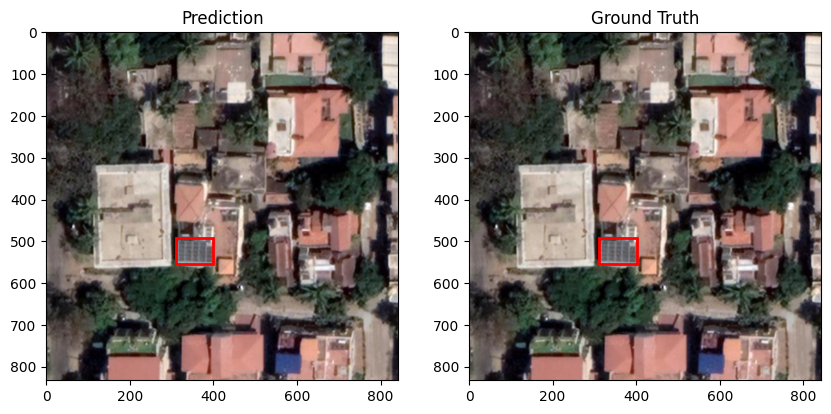

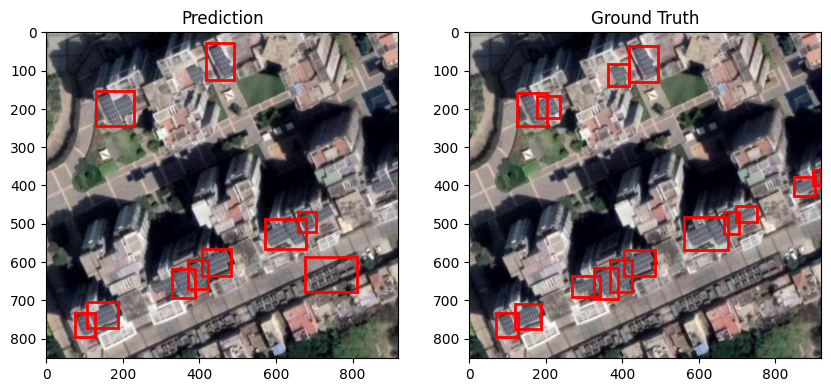

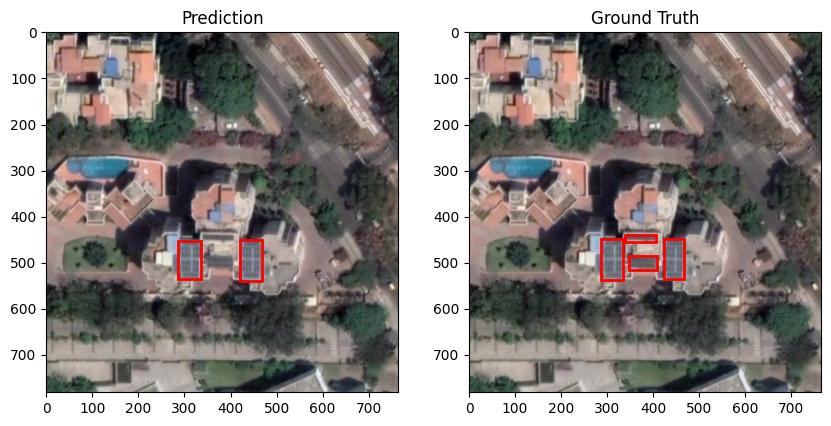

In [123]:
# plot image with predicted bounding boxes and ground truth bounding boxes side by side using plot_img_bbox

def plot_img_bbox_side_by_side(image, prediction, ground_truth):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')
    ax[0].imshow(image)
    ax[1].imshow(image)
    for box in prediction['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
    for box in ground_truth['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    plt.show()


for i in images:
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/img/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plot_img_bbox_side_by_side(img, predict(img), labels[int(i.split('.')[0])-1])

In [124]:
predictions = []

for i in images:
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_blr/img/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictions.append(predict(img))


In [148]:
# find each coordinate of a pixel covered by the bounding boxes of the predictions and ground truth

prediction_pixels = []
ground_truth_pixels = []

for i in range(len(predictions)):
    prediction_pixels.append([])
    ground_truth_pixels.append([])
    for box in predictions[i]['boxes']:
        xmin, ymin, xmax, ymax = box
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                prediction_pixels[i].append((x, y))
    for box in labels[i]['boxes']:
        xmin, ymin, xmax, ymax = box
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                ground_truth_pixels[i].append((x, y))

# compute the intersection over union for each image

iou = []

for i in range(len(prediction_pixels)):
    iou.append(len(set(prediction_pixels[i]).intersection(set(ground_truth_pixels[i])))/len(set(prediction_pixels[i]).union(set(ground_truth_pixels[i]))))

iou


[0.378622151920035,
 0.0,
 0.4406943883730319,
 0.7512383048981838,
 0.821954210956664,
 0.36831526810709925,
 0.7944011352536813,
 0.9096604022420046,
 0.5809289094555798,
 0.6641202358216391]

In [153]:
import statistics

results = {
    'average_iou': str(100*sum(iou)/len(iou))+ '%',
    'median_iou': str(100*statistics.median(iou))+ '%',
    'max': str(max(iou)*100)+ '%',
    'min': str(min(iou)*100)+ '%'
}
results

{'average_iou': '57.099350070279186%',
 'median_iou': '62.25245726386095%',
 'max': '90.96604022420046%',
 'min': '0.0%'}